In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
# The complete pipeline from snapshot to power spectrum
#
# snapshot_interp_block.py : 1. Load the snapshot
#                            2. Block decomposition and interpolation > n^3 blocks of size ?^3
# block_fold_phi.py        : 3. Apply phase and fold the fields > up to m^3 complex fields of size 2048^3 
# phi_FFT_sub_spctrm.py    : 4. Calculate the power spectrum for each beta > up to m^3 power spectra
# sub_to_full_spctrm.py    : 5. Combine the power spectra > 1 final power spectra

In [2]:
params_config = """
[file_params]
SNAPSHOT = '/appalachia/d5/DISK/from_pleiades/snapshots/gmcs0_wind4_gmc9/snapshot_550.hdf5'
# The output will be in a subfolder under OUTPUT_DIR.
OUTPUT_DIR = './output'

[interp_params]
# number of blocks, 16, 4
nblocks = 4
# Nsize of each block, 1024, 4096. target Ng = 16384
Nblock = 1024
smoothing_rate = 1.
voxelize_threads = 16

[spctrm_params]
m = 8
fftw_threads = 16
"""
!echo '{params_config}' > params_config.ini
!cat params_config.ini


[file_params]
SNAPSHOT = /appalachia/d5/DISK/from_pleiades/snapshots/gmcs0_wind4_gmc9/snapshot_550.hdf5
# The output will be in a subfolder under OUTPUT_DIR.
OUTPUT_DIR = ./output

[interp_params]
# number of blocks, 16, 4
nblocks = 2
# Nsize of each block, 1024, 4096. target Ng = 16384
Nblock = 64
smoothing_rate = 1.

[spctrm_params]
m = 4
fft_threads = 16



## `snapshot_interp_block.py`

In [1]:
%%writefile snapshot_interp_block.py
from configparser import ConfigParser

conf = ConfigParser()
conf.read('params_config.ini')
OUTPUT_DIR = conf.get('file_params','OUTPUT_DIR')
SNAPSHOT = conf.get('file_params','SNAPSHOT')
nblocks = conf.getint('interp_params', 'nblocks')
Nblock = conf.getint('interp_params', 'Nblock')
threads = conf.getint('interp_params', 'voxelize_threads')
smoothing_rate = conf.getfloat('interp_params', 'smoothing_rate')

import os
os.environ['OMP_NUM_THREADS'] = str(threads+1)

from utils_folding import SimulationParticles, init_dir

# Initialize output directory for this run
RUN_OUTPUT_DIR = os.path.join(OUTPUT_DIR, 'Ng{}Nb{}'.format(Nblock*nblocks, Nblock))
init_dir(RUN_OUTPUT_DIR, auto_overwrite=True)
conf.set('file_params', 'RUN_OUTPUT_DIR', RUN_OUTPUT_DIR)
with open('params_config.ini', 'w') as f:
	conf.write(f)

# Interpolation
simParticles = SimulationParticles.load_snapshot(SNAPSHOT, remove_bulk_velocity=True, shift_to_origin=True)
blocksDecomp = simParticles.interp_to_blocks(RUN_OUTPUT_DIR, nblocks=nblocks, Nblock=Nblock,
                                          smoothing_rate=smoothing_rate) # Folded fields are saved in the process
blocksDecomp.save() # Save the decomp object

Overwriting snapshot_interp_block.py


In [2]:
import sys
!{sys.executable} -m mprof run --multiprocess --include-children snapshot_interp_block.py

mprof.py: Sampling memory every 0.1s
running new process
Only the CPU-only flavour of Voxelize is available!
Overwriting...
Output folder of this run: ./output/Ng128Nb64
Padding:  0.0639142955062747 Lbox:  0.6278285910125494 Nsize:  80
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
root_add_process : started ...
workers_process : started ...
workers using 35 threads.
Workers processed 4560652 numbers, of which were
	0.000e+00 exact calculations (R<Rmin),
	4.287e+06 exact calculations (R>Rmax),
	2.737e+05 trivial calculations,
	0.000e+00 interpolations.

workers_process : ended.
Root processed 4560652 numbers in 158 CPU-chunks.
root_add_process : ended.
voxelize_gpu function took 0.4403 seconds
In the end, 0 in cpu_queue
Padding:  0.04116758416095456 Lbox:  0.5823351683219091 Nsize:  74
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
root_add_process : started ...
workers_process : started

In [4]:
!{sys.executable} -m mprof plot -f -o snapshot_interp_block.png

Using last profile data.


## `block_fold_phi.py`

In [1]:
%%writefile block_fold_phi.py
from utils_folding import BlocksDecomposition
from utils_spctrm import random_beta_sequence
from configparser import ConfigParser

conf = ConfigParser()
conf.read('params_config.ini')
RUN_OUTPUT_DIR = conf.get('file_params','RUN_OUTPUT_DIR')
m = conf.getint('spctrm_params', 'm')

blocksDecomp = BlocksDecomposition.load(RUN_OUTPUT_DIR)
beta_sequence = random_beta_sequence(m=m, seed=1)
for beta in beta_sequence:
  foldedField3D = blocksDecomp.fold(m=m, beta=beta, quantity='velocity')
  foldedField3D.save(RUN_OUTPUT_DIR)

Only the CPU-only flavour of Voxelize is available!



KeyboardInterrupt



## `phi_FFT_sub_spctrm.py`
To-dos:
1. Use `pyfft.FFTW` instead of `pyfftw.interfaces`
2. One component at a time to save memory consumption

In [5]:
%%writefile phi_FFT_sub_spctrm.py
from utils_folding import FoldedField3D
from configparser import ConfigParser

conf = ConfigParser()
conf.read('params_config.ini')
RUN_OUTPUT_DIR = conf.get('file_params','RUN_OUTPUT_DIR')
m = conf.getint('spctrm_params', 'm')
threads = conf.getint('spctrm_params', 'fftw_threads')

a = pyfftw.empty_aligned((Nsize, Nsize, Nsize, 3), dtype='complex64')
fft_object = pyfftw.FFTW(a, a, axes=(0, 1, 2), threads=threads)

beta_sequence = random_beta_sequence(m=m, seed=1)
for beta in beta_sequence:
  foldedField3D = FoldedField3D.load(RUN_OUTPUT_DIR, beta=beta) ### Update: component by component?
  subSpctrm = foldedField3D.fold_spctrm(beta=beta) # FFT
  subSpctrm.save(RUN_OUTPUT_DIR)

/appalachia/d6/yujie/Test_PowerSpec/utils_folding.py:696: RuntimeWarning: invalid value encountered in true_divide
  P = Psum/Nsample


## `sub_to_full_spctrm.py`

In [7]:
%%writefile sub_to_full_spctrm.py
from utils_spctrm import SpectrumList
from configparser import ConfigParser

conf = ConfigParser()
conf.read('params_config.ini')
RUN_OUTPUT_DIR = conf.get('file_params','RUN_OUTPUT_DIR')
m = conf.getint('spctrm_params', 'm')

spctrmList = SpectrumList.load(RUN_OUTPUT_DIR)
fullSpctrm = spctrmList.combine_all()
fullSpctrm.save(RUN_OUTPUT_DIR)

/appalachia/d6/yujie/Test_PowerSpec/utils_spctrm.py:81: RuntimeWarning: invalid value encountered in true_divide
  self.P = self.Psum / self.Nsample * (4*np.pi*self.k**2)


Visualize

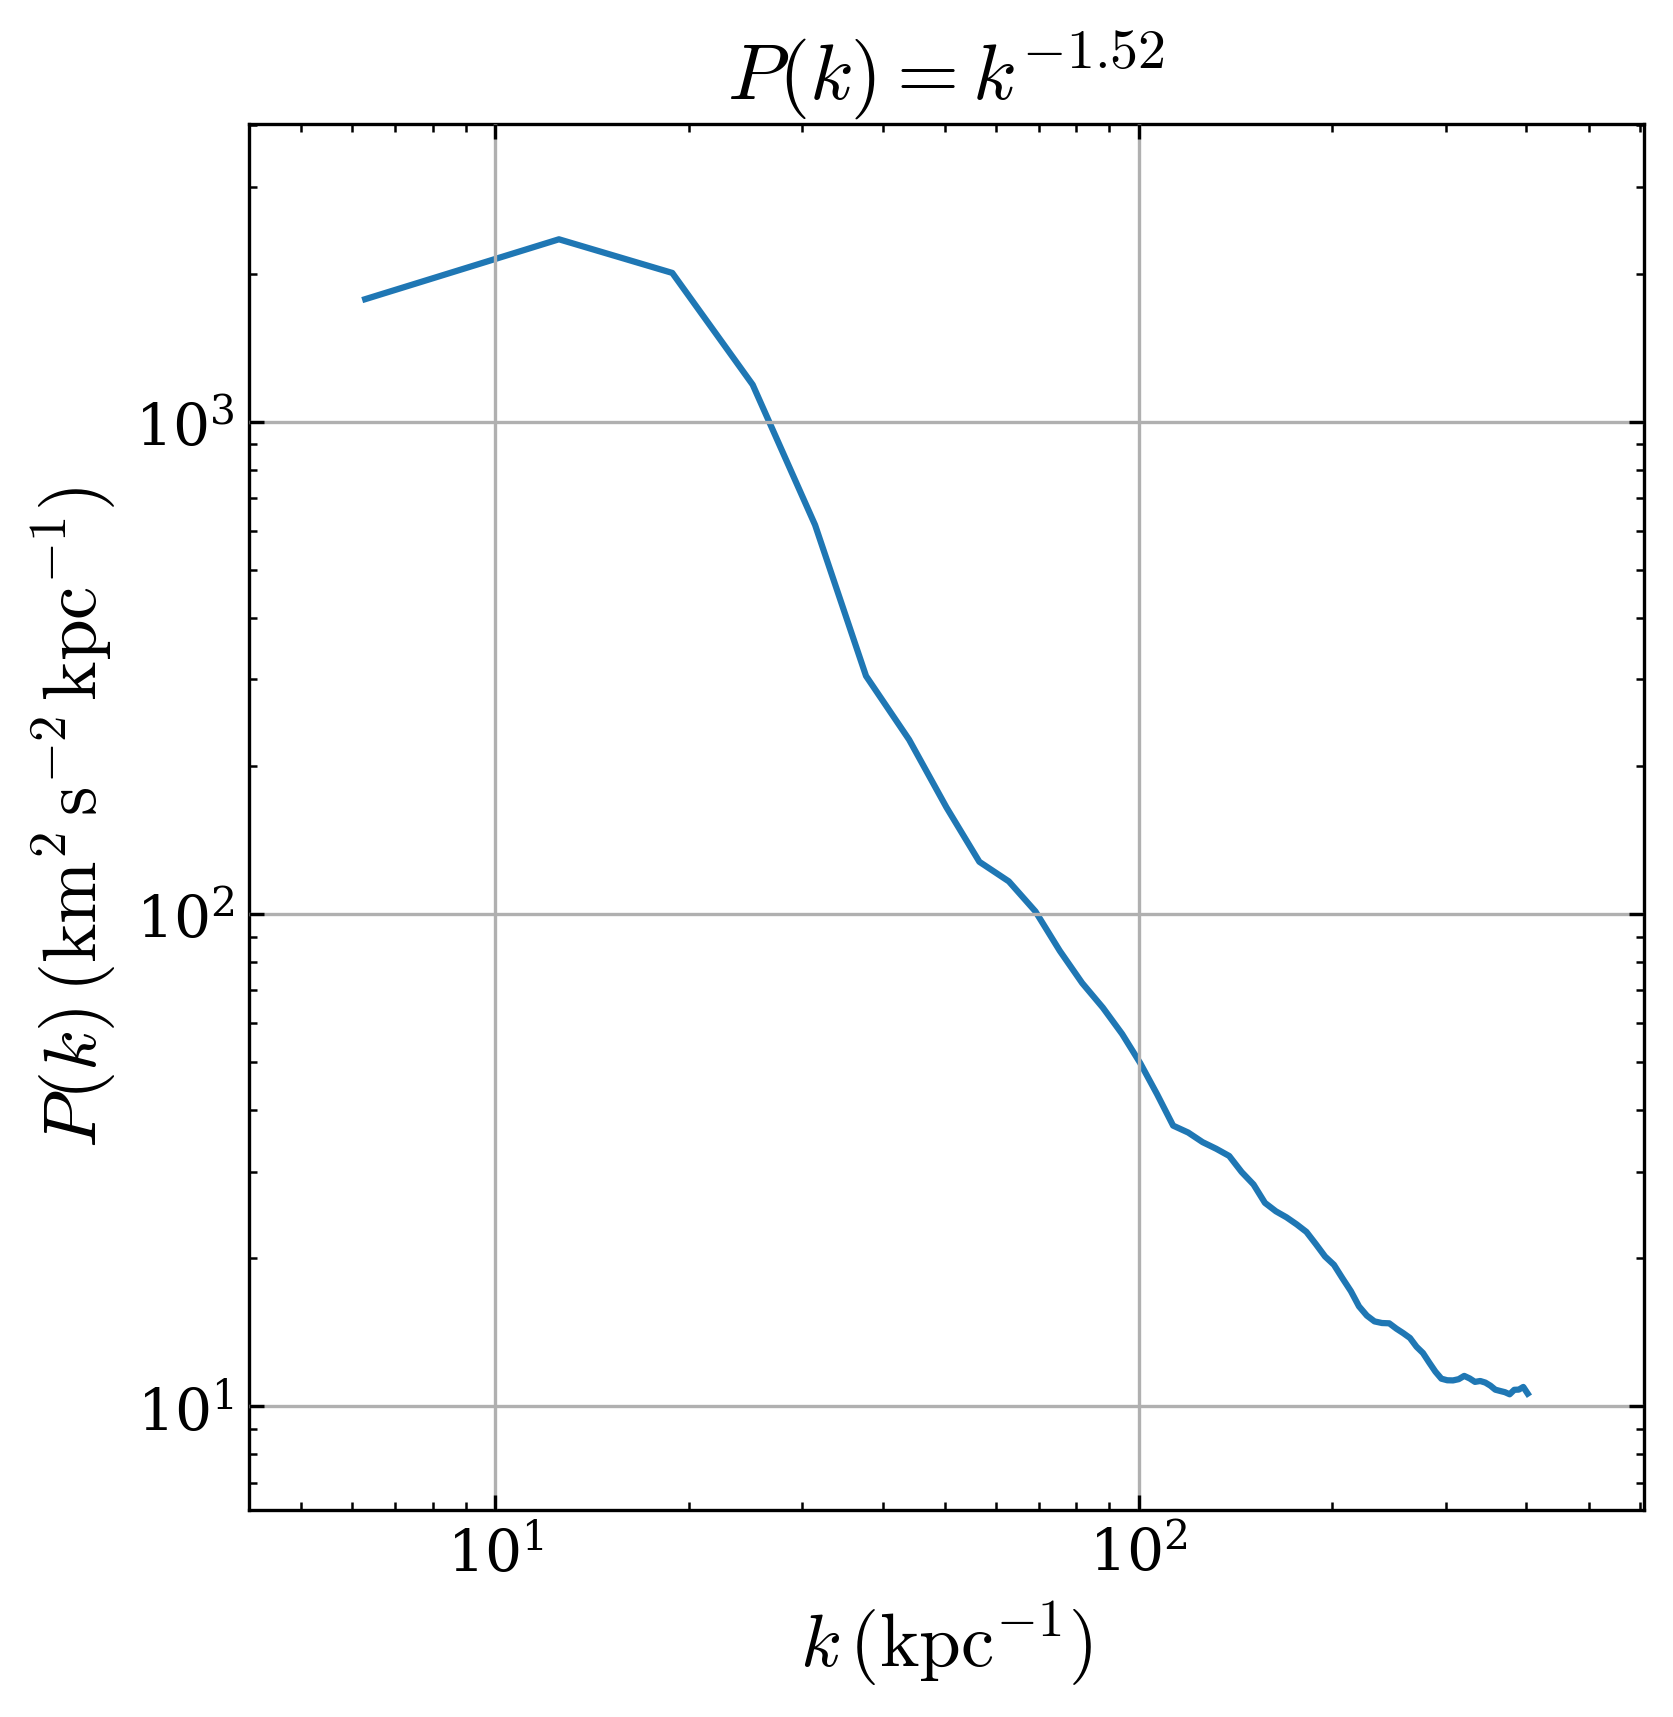

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('./niceplot2jay.mplstyle')
from utils_spctrm import PowerSpectrum
from configparser import ConfigParser

conf = ConfigParser()
conf.read('params_config.ini')
RUN_OUTPUT_DIR = conf.get('file_params','RUN_OUTPUT_DIR')

pwrSpctrm = PowerSpectrum.load(RUN_OUTPUT_DIR)
pwrSpctrm.peek()